In [1]:
import numpy as np
import matplotlib.pyplot as plt
import legwork as lw
import astropy.units as u
import tqdm
from astropy.cosmology import Planck18, z_at_value
from scipy.integrate import trapz, cumtrapz
from schwimmbad import MultiPool
from utils import get_LISA_norm, get_LISA_norm_circular, dTmerger_df_circ, get_t_evol_LISA
from scipy.interpolate import interp1d

In [2]:
def get_LIGO_rate_uniform_e(m1, delta_m):
    if m1 <= 8:
        rate = 30
    elif m1 <= 15:
        rate = 0.5
    elif m1 <= 30:
        rate = 0.1
    elif m1 <= 40:
        rate = 0.2
    elif m1 <= 50:
        rate = 0.05
    elif m1 <= 60:
        rate = 0.005
    else:
        rate = 0.001
    rate = np.array(rate) * u.Gpc**(-3) * u.yr**(-1) * u.Msun**(-1)
    integrated_rate = rate * delta_m * u.Msun
    
    return integrated_rate
        
    
def get_LIGO_rate_iso_dyn(m1, e, frac_iso):
    if m1 < 20:
        if e < 1e-6:
            rate = 20 * frac_iso * u.Gpc**(-3) * u.yr**(-1)
        else:
            rate = 20 * (1-frac_iso) * u.Gpc**(-3) * u.yr**(-1)
    elif m1 < 50:
        if e < 1e-6:
            rate = 4.5 * frac_iso * u.Gpc**(-3) * u.yr**(-1)
        else:
            rate = 4.5 * (1-frac_iso) * u.Gpc**(-3) * u.yr**(-1)
    elif m1 <= 100:
        if e < 1e-6:
            rate = 0.2 * frac_iso * u.Gpc**(-3) * u.yr**(-1)
        else:
            rate = 0.2 * (1-frac_iso) * u.Gpc**(-3) * u.yr**(-1)
        
    return rate


def ligo_rate(m1):
    dat = np.array([[3.705799151343708, 0.001087789470121345],
                   [4.384724186704389, 0.00984816875074369],
                   [5.063649222065067, 0.06979974252228799],
                   [5.827439886845831, 0.41173514594201527],
                   [6.506364922206512, 1.3579705933006465],
                   [6.845827439886847, 2.148948034692836],
                   [7.77934936350778, 2.7449738151212433],
                   [8.543140028288544, 2.6218307403757986],
                   [9.561527581329564, 2.0525434471508692],
                   [11.173974540311175, 1.2388629239937763],
                   [12.701555869872706, 0.7828664968878465],
                   [14.398868458274404, 0.4947116747780942],
                   [16.859971711456865, 0.2895969742197884],
                   [19.66053748231967, 0.17748817964452962],
                   [22.206506364922213, 0.12773570001722281],
                   [24.837340876944843, 0.10389898279212807],
                   [27.722772277227726, 0.1087789470121345],
                   [30.183875530410184, 0.13070104796093673],
                   [32.729844413012735, 0.16441704701060267],
                   [34.85148514851486, 0.16695189854274867],
                   [37.397454031117405, 0.12107555776371784],
                   [39.26449787835927, 0.08010405199404155],
                   [41.30127298444131, 0.049851062445855264],
                   [43.592644978783596, 0.029631988560550687],
                   [45.629420084865636, 0.018440841322693136],
                   [48.0905233380481, 0.011832859313068754],
                   [50.891089108910904, 0.007949361111716631],
                   [53.77652050919379, 0.005764973856945108],
                   [57.25601131541727, 0.0043438393396653925],
                   [61.923620933521946, 0.0032730313574784275],
                   [66.67609618104669, 0.0024851284269805634],
                   [70.66478076379069, 0.002068305171949823],
                   [74.82319660537483, 0.0016952583040389245],
                   [78.72701555869875, 0.0013476220436441713],
                   [81.27298444130128, 0.0010389898279212807]])
    
    mass = dat[:,0]
    rate = dat[:,1]
    interp_rate = interp1d(mass, rate)
    
    return interp_rate(m1)

## First look at the circular case

In [ ]:
n_grid = 50

f = np.logspace(-1, -5, n_grid) * u.Hz

masses = np.linspace(5, 80, n_grid)
m_bin_widths = masses[1] - masses[0]
mass_bins = masses - 0.5 * m_bin_widths
mass_bins = np.append(mass_bins, masses[-1] + 0.5 * m_bin_widths)
masses = masses * u.Msun
mass_bins = mass_bins * u.Msun

m_c = lw.utils.chirp_mass(masses, masses)
F, MASS = np.meshgrid(f, masses)

MC = lw.utils.chirp_mass(MASS, MASS)

RATE = ligo_rate(MASS.flatten().value)
RATE = RATE.reshape(MC.shape) * u.Gpc**(-3) * u.yr**(-1)

In [ ]:
t_merge = lw.evol.get_t_merge_circ(f_orb_i=F, m_1=MASS, m_2=MASS)

In [ ]:
source = lw.source.Source(m_1=MASS.flatten(),
                          m_2=MASS.flatten(),
                          ecc=np.zeros(len(F.flatten())),
                          f_orb=F.flatten(),
                          dist=8 * np.ones(len(F.flatten())) * u.Mpc,
                          interpolate_g=False,
                          n_proc=36)
snr = source.get_snr(approximate_R=True, verbose=True)
D_h = snr/7 * 8 * u.Mpc
redshift = np.ones(len(D_h)) * 1e-8
redshift[D_h > 0.0001 * u.Mpc] = z_at_value(Planck18.luminosity_distance, D_h[D_h > 0.0001 * u.Mpc])
horizon_comoving_volume = Planck18.comoving_volume(z=redshift)
horizon_comoving_volume = horizon_comoving_volume.reshape(RATE.shape)
D_h = D_h.reshape(RATE.shape)

In [ ]:
plt.scatter(F, MC, c=np.log10(t_merge.to(u.yr).value))
plt.colorbar(label='log$_{10}$(merger time/yr)')
plt.xlabel('orbital frequency [Hz]')
plt.ylabel('chirp mass [Msun]')
plt.xscale('log')

In [ ]:
plt.scatter(F, MC, c=np.log10((RATE * t_merge).to(u.Gpc**(-3)).value))
plt.colorbar(label='log$_{10}$(Rate per comoving Mpc$^3$)')
plt.xlabel('orbital frequency [Hz]')
plt.ylabel('chirp mass [Msun]')
plt.xscale('log')

In [ ]:
plt.scatter(F, MASS, c=np.log10(horizon_comoving_volume.to(u.Gpc**(3)).value), vmin=0, vmax=np.log10(0.7))
plt.colorbar()
plt.xscale('log')

In [ ]:
N_samp = (RATE * t_merge).to(u.Gpc**(-3)) * 0.5 * u.Gpc**3
print(np.shape(N_samp))

z_lim = z_at_value(Planck18.comoving_volume, 0.5 * u.Gpc**3)
d_lim = Planck18.luminosity_distance(z=z_lim)

In [ ]:
dat = []
for kk in tqdm.tqdm(range(5)):
    m_samp = []
    f_samp = []
    D_samp = []
    for ii, m in enumerate(masses):
        for jj, freq in enumerate(f):
            if freq < 2e-4 * u.Hz:
                n_samp = (RATE[ii,jj] * t_merge[ii,jj]).to(u.Mpc**(-3)) * 1 * u.Mpc**3
                z_lim = z_at_value(Planck18.comoving_volume, 1 * u.Mpc**3)
                d_lim = Planck18.luminosity_distance(z=z_lim)
            else:
                n_samp = (RATE[ii,jj] * t_merge[ii,jj]).to(u.Gpc**(-3)) * 0.5 * u.Gpc**3
                z_lim = z_at_value(Planck18.comoving_volume, 0.5 * u.Gpc**3)
                d_lim = Planck18.luminosity_distance(z=z_lim)
    
            # Decide on how many sources at this freq, mass to sample 
            n_int = int(n_samp)
            n_float = n_samp - n_int
            add_check = np.random.uniform(0, 1)
            if add_check < n_float:
                n_int += 1
            if n_int > 1:
                d_samp = np.random.power(3, n_int) * d_lim
                
                ind_keep, = np.where(d_samp < D_h[ii,jj])
                if len(ind_keep) > 0:
                    m_samp.extend(np.random.uniform(mass_bins[ii].value, mass_bins[ii+1].value, len(ind_keep)))
                    f_samp.extend(np.ones(len(ind_keep)) * freq.value)
                    D_samp.extend(d_samp[ind_keep].to(u.Mpc).value)
    dat.append([m_samp, f_samp, D_samp])
                
                
                
        

In [ ]:
n_obs = []
for d in dat:
    m_samp, f_samp, D_samp = d
    n_obs.append(len(m_samp))
    plt.scatter(f_samp, lw.utils.chirp_mass(np.array(m_samp), np.array(m_samp)), c=D_samp, vmin=10, vmax=200)
plt.colorbar()
plt.xscale('log')
plt.xlabel('frequency [Hz]')
plt.ylabel('chirp mass [Msun]')
plt.title(f'Number per LISA observation is {np.mean(n_obs)}', size=20)

## Next up is to MC sample over eccentricity with q=1

In [55]:
n_grid = 25

f = np.logspace(-1, -4, n_grid) * u.Hz
f_bins = f[1:] - f[:-1]

masses = np.linspace(5, 80, n_grid)
m_bin_widths = masses[1] - masses[0]
mass_bins = masses - 0.5 * m_bin_widths
mass_bins = np.append(mass_bins, masses[-1] + 0.5 * m_bin_widths)
masses = masses * u.Msun
mass_bins = mass_bins * u.Msun

ecc = np.logspace(-9, -4, n_grid)
ecc_bins = ecc[1:] - ecc[:-1]

m_c = lw.utils.chirp_mass(masses, masses)
F, MASS, ECC = np.meshgrid(f, masses, ecc)

MC = lw.utils.chirp_mass(MASS, MASS)

RATE = ligo_rate(MASS.flatten().value)
RATE = RATE.reshape(MC.shape) * u.Gpc**(-3) * u.yr**(-1)

In [56]:
print(F.flatten().min())

0.0001 Hz


In [76]:
with MultiPool(processes=1) as pool:
    T_LISA = np.array(list(pool.map(get_t_evol_LISA, zip(MASS.flatten(), MASS.flatten(), ECC.flatten(), F.flatten()))))


In [80]:
print(T_LISA.reshape(F.shape)[0], F[0])

[[-4.03676285e+06 -4.03931713e+06 -4.03583917e+06 -4.03909609e+06
  -4.03690123e+06 -4.04152183e+06 -4.04945987e+06 -4.05313496e+06
  -4.05833689e+06 -4.06422950e+06 -4.06627276e+06 -4.07262896e+06
  -4.07694577e+06 -4.07904386e+06 -4.07949221e+06 -4.07927231e+06
  -4.07865707e+06 -4.07762307e+06 -4.07672404e+06 -4.07797547e+06
  -4.07855241e+06 -4.07746267e+06 -4.07691397e+06 -4.07740686e+06
  -4.07411041e+06]
 [-8.72010381e+06 -8.71717103e+06 -8.72062127e+06 -8.71308416e+06
  -8.72053635e+06 -8.72219181e+06 -8.72472116e+06 -8.74275020e+06
  -8.75148871e+06 -8.75846281e+06 -8.76307026e+06 -8.78446760e+06
  -8.78749545e+06 -8.78780189e+06 -8.78795744e+06 -8.78872558e+06
  -8.78943758e+06 -8.78893656e+06 -8.78498680e+06 -8.78383465e+06
  -8.78691328e+06 -8.78253192e+06 -8.78521931e+06 -8.77868047e+06
  -8.77676624e+06]
 [-1.87834132e+07 -1.87693225e+07 -1.87783943e+07 -1.87815967e+07
  -1.87844952e+07 -1.88051166e+07 -1.88260231e+07 -1.88536822e+07
  -1.88660216e+07 -1.88773121e+07 -1.8

In [82]:
T_LISA = T_LISA.reshape(MASS.shape) * u.s

In [83]:
np.shape(T_LISA)

(25, 25, 25)

In [84]:
a_evol, e_evol, f_evol = lw.evol.evol_ecc(
    m_1=MASS.flatten(), m_2=MASS.flatten(), f_orb_i=10*u.Hz, ecc_i=ECC.flatten(), t_evol = T_LISA.flatten(),
            t_before=0.01*u.yr, output_vars=["a", "ecc", "f_orb"], avoid_merger=False, n_step=2)

In [85]:
f_evol = f_evol.reshape((len(f), len(masses), len(ecc), 2))[:,:,:,1]
e_evol = e_evol.reshape((len(f), len(masses), len(ecc), 2))[:,:,:,1]

In [86]:
(F.flatten() - f_evol.flatten())/F.flatten()

<Quantity [-0.00074136, -0.00050412, -0.0008272 , ..., -0.00010049,
           -0.00012485, -0.00055066]>

In [63]:
source = lw.source.Source(m_1=MASS.flatten(),
                          m_2=MASS.flatten(),
                          ecc=e_evol.flatten(),
                          f_orb=F.flatten(),
                          dist=8 * np.ones(len(F.flatten())) * u.Mpc,
                          interpolate_g=False,
                          n_proc=1)
snr = source.get_snr(approximate_R=True, verbose=True)
D_h = snr/7 * 8 * u.Mpc
redshift = np.ones(len(D_h)) * 1e-8
redshift[D_h > 0.0001 * u.Mpc] = z_at_value(Planck18.luminosity_distance, D_h[D_h > 0.0001 * u.Mpc])
horizon_comoving_volume = Planck18.comoving_volume(z=redshift)
horizon_comoving_volume = horizon_comoving_volume.reshape(MASS.shape)
D_h = D_h.reshape(MASS.shape)

Calculating SNR for 15625 sources
	0 sources have already merged
	6612 sources are stationary
		4437 sources are stationary and circular
		2175 sources are stationary and eccentric
	9013 sources are evolving
		8088 sources are evolving and circular
		925 sources are evolving and eccentric


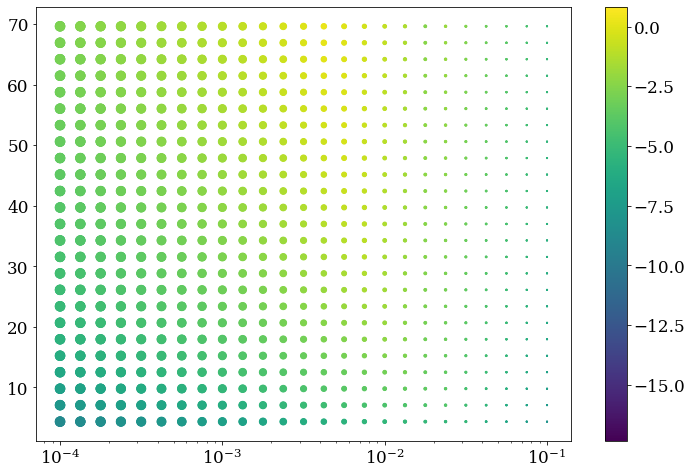

In [64]:
plt.scatter(F, MC, c=np.log10(horizon_comoving_volume.to(u.Gpc**3).value), s=100*e_evol)
plt.xscale('log')
plt.colorbar()

In [73]:
np.shape(e_evol)

(25, 25, 25)

In [87]:
dat = []
for ii in range(1):
    m_samp = []
    e_samp = []
    f_samp = []
    D_samp = []
    for ii, m in enumerate(masses):
        for jj, e in enumerate(ecc[1:]):
            for kk, freq in enumerate(f[1:]):
                n_per_Gpc3 = (RATE[kk+1, ii, jj+1] * -1 * T_LISA[kk+1, ii, jj+1]).to(u.Gpc**(-3))  
                n_samp = n_per_Gpc3 * 1 * u.Gpc**3
                z_lim = z_at_value(Planck18.comoving_volume, 1 * u.Gpc**3)
                d_lim = Planck18.luminosity_distance(z=z_lim)
                # Decide on how many sources at this freq, mass to sample 
                n_int = int(n_samp)
                n_float = n_samp - n_int
                add_check = np.random.uniform(0, 1)
                if add_check < n_float:
                    n_int += 1
                if n_int > 1:
                    d_samp = np.random.power(3, n_int) * d_lim
                    
                    ind_keep, = np.where(d_samp < D_h[kk+1, ii, jj+1])
                    if len(ind_keep) > 0:
                        m_samp.extend(np.random.uniform(mass_bins[ii].value, mass_bins[ii+1].value, len(ind_keep)))
                        e_samp.extend(np.ones(len(ind_keep)) * e_evol[kk+1, ii, jj+1])
                        f_samp.extend(np.random.uniform(freq_bins[jj].value, freq_bins[jj+1].value, len(ind_keep)))
                        D_samp.extend(d_samp[ind_keep].to(u.Mpc).value)
    dat.append([m_samp, f_samp, e_samp, D_samp])
            

5.0 solMass 2.0864658940849124e-07 0.07498942093324558 Hz -1800469.8201729665 s
5.0 solMass 2.0862721939582917e-07 0.05623413251903491 Hz -1046490.6370336136 s
5.0 solMass 2.085324985794148e-07 0.042169650342858224 Hz -694722.4068671564 s
5.0 solMass 2.0850401227919947e-07 0.03162277660168379 Hz -500354.3590362644 s
5.0 solMass 2.0856485453737434e-07 0.023713737056616554 Hz -380777.64116456494 s
5.0 solMass 2.08658505123734e-07 0.01778279410038923 Hz -301333.99266616197 s
5.0 solMass 2.0869986221573584e-07 0.01333521432163324 Hz -245352.7375014463 s
5.0 solMass 2.0872836653025093e-07 0.01 Hz -204324.06412560074 s
5.0 solMass 2.0867519407051737e-07 0.007498942093324558 Hz -173107.33226186052 s
5.0 solMass 2.0870560216088565e-07 0.005623413251903491 Hz -149012.214142347 s
5.0 solMass 2.0864752469796984e-07 0.004216965034285823 Hz -129736.47826562951 s
5.0 solMass 2.0861973391078103e-07 0.0031622776601683794 Hz -114191.89549659814 s
5.0 solMass 2.0862987173490473e-07 0.0023713737056616554

NameError: name 'freq_bins' is not defined

In [ ]:
dat

In [ ]:
V_c = []
LIGO_rate_uniform = []
LIGO_rate_iso_dyn_50 = []
LIGO_rate_iso_dyn_80 = []
times = []
ecc_evols = []
f_orb_evols = []
LISA_norms = []
m1_evols = []
m2_evols = []


for d, m1, m2, e in tqdm.tqdm(zip(dat_out, M1, M2, E), total=len(M1)):
    f_orb_evol, ecc_evol, timesteps, LISA_norm = d
    f_mask = f_orb_evol < 0.3 * u.Hz
    source = lw.source.Source(m_1=m1 * np.ones(len(f_orb_evol[f_mask])) * u.Msun,
                              m_2=m2 * np.ones(len(f_orb_evol[f_mask])) * u.Msun,
                              ecc=ecc_evol[f_mask],
                              f_orb=f_orb_evol[f_mask],
                              dist=8 * np.ones(len(f_orb_evol[f_mask])) * u.Mpc,
                              interpolate_g=False,
                              n_proc=nproc)
    snr = source.get_snr(approximate_R=True, verbose=False)
    D_h = snr/7 * 8 * u.Mpc
    redshift = np.ones(len(D_h)) * 1e-8
    redshift[D_h > 0.0001 * u.Mpc] = z_at_value(Planck18.luminosity_distance, D_h[D_h > 0.0001 * u.Mpc])
    V_c.append(Planck18.comoving_volume(z=redshift))

    LISA_norms.append(LISA_norm[f_mask].to(u.yr/u.Hz))
    times.append(-timesteps[f_mask].to(u.yr))
    ecc_evols.append(ecc_evol[f_mask])
    f_orb_evols.append(f_orb_evol[f_mask])
    m1_evols.append(m1 * np.ones(len(f_orb_evol[f_mask])))
    m2_evols.append(m2 * np.ones(len(f_orb_evol[f_mask])))
    LIGO_rate_uniform.append(get_LIGO_rate_uniform_e(m1, delta_m[0]))
    LIGO_rate_iso_dyn_50.append(get_LIGO_rate_iso_dyn(m1, e, frac_iso=0.5))
    LIGO_rate_iso_dyn_80.append(get_LIGO_rate_iso_dyn(m1, e, frac_iso=0.8))


In [ ]:
def get_m_lo(m1, mass_grid):
    return min(mass_grid[mass_grid < m1])
    

In [ ]:
print(n_grid)
m1_keep = []
m2_keep = []
f_keep = []
for ii, m1, m2 in zip(range(len(M1)), M1, M2):
    print(m1, m2)
    ligo_rate = get_LIGO_rate_uniform_e(m1, delta_m[0]) / n_grid
    f = f_orb_evols[ii]
    v_c = V_c[ii]
    
    l_norm = LISA_norms[ii] * (u.yr/u.Hz)
    t_evol = times[ii]
    
    # first select out everything that's below a millihertz
    ind_mhz, = np.where(f < 0.001 * u.Hz)
    ind_mhz_gtr, = np.where(f >= 0.001 * u.Hz)
        
    t_max_lo = max(t_evol[ind_mhz])
    v_max_lo = max(v_c[ind_mhz].to(u.Mpc**3))
    n_sample_lo = int(ligo_rate.to(u.Mpc**(-3)/u.yr) * v_max_lo * t_max_lo)
    t_f_interp = interp1d(t_evol[ind_mhz], f[ind_mhz])
    v_c_interp = interp1d(f[ind_mhz], v_c[ind_mhz])
    
    m_lo = get_m_lo(m1, mass1_grid)
    m1_sample = np.random.uniform(m_lo, m1, n_sample_lo)
    m2_sample = np.random.uniform(5 * np.ones(n_sample_lo), m1_sample)
    t_sample = np.random.uniform(min(t_evol[ind_mhz]).value, t_max_lo.value, n_sample_lo)
    f_sample = t_f_interp(t_sample)
    v_max = v_c_interp(f_sample)
    d_max = 3/(4 * np.pi) * v_max_lo**(1/3)
    
    d = np.random.power(3, n_sample_lo) * (3/(4 * np.pi) * max(v_c[ind_mhz].value))**(1/3) * u.Mpc
    source = lw.source.Source(m_1=m1_sample * u.Msun,
                              m_2=m2_sample * u.Msun,
                              ecc=np.zeros(len(m1_sample)),
                              f_orb=f_sample * u.Hz,
                              dist=8 * np.ones(len(f_sample)) * u.Mpc,
                              interpolate_g=False,
                              n_proc=nproc)
    snr = source.get_snr(approximate_R=True, verbose=False)
    keep_mask = snr  > 7
    m1_keep.extend(m1_sample[keep_mask])
    m2_keep.extend(m2_sample[keep_mask])
    f_keep.extend(f_sample[keep_mask])
    print(f"sample {n_sample_lo} mergers below 1 mHz and keep {len(keep_mask[keep_mask])} of them")
    
    t_max = max(t_evol[ind_mhz_gtr])
    v_max = max(v_c[ind_mhz_gtr].to(u.Mpc**3))
    n_sample = int(ligo_rate.to(u.Mpc**(-3)/u.yr) * v_max * t_max)
    
    
    t_f_interp = interp1d(t_evol[ind_mhz_gtr], f[ind_mhz_gtr])
    v_c_interp = interp1d(f[ind_mhz_gtr], v_c[ind_mhz_gtr])
    m_lo = get_m_lo(m1, mass1_grid)
    m1_sample = np.random.uniform(m_lo, m1, n_sample)
    m2_sample = np.random.uniform(5 * np.ones(n_sample), m1_sample)
    t_sample = np.random.uniform(0, t_max.value, n_sample)
    f_sample = t_f_interp(t_sample)
    v_max = v_c_interp(f_sample)
    d_max = 3/(4 * np.pi) * v_max**(1/3)
    
    d = np.random.power(3, n_sample) * (3/(4 * np.pi) * max(v_c.value))**(1/3)
    d = np.random.power(3, n_sample_lo) * (3/(4 * np.pi) * max(v_c[ind_mhz].value))**(1/3) * u.Mpc
    source = lw.source.Source(m_1=m1_sample * u.Msun,
                              m_2=m2_sample * u.Msun,
                              ecc=np.zeros(len(m1_sample)),
                              f_orb=f_sample * u.Hz,
                              dist=8 * np.ones(len(f_sample)) * u.Mpc,
                              interpolate_g=False,
                              n_proc=nproc)
    snr = source.get_snr(approximate_R=True, verbose=False)
    keep_mask = snr  > 7
    m1_keep.extend(m1_sample[keep_mask])
    m2_keep.extend(m2_sample[keep_mask])
    f_keep.extend(f_sample[keep_mask])
    print(f"sample {n_sample} mergers above 1 mHz and keep {len(keep_mask[keep_mask])} of them")
    print()


In [ ]:
m_c = lw.utils.chirp_mass(m1_keep * u.Msun, m2_keep * u.Msun)
print(len(m_c))

In [ ]:
m_c = lw.utils.chirp_mass(m1_keep * u.Msun, m2_keep * u.Msun)
print(len(m_c))

In [ ]:
plt.scatter(f_keep, m_c)
plt.xscale('log')

In [ ]:
m_c = lw.utils.chirp_mass(m1_keep * u.Msun, m2_keep * u.Msun)
print(len(m_c))

In [ ]:
plt.scatter(f_keep, m_c)
plt.xscale('log')